# Project 3 - FYS-STK4155
## Neural network using PyTorch and application to weather classification

This notebook contains the code which produces the results for the Project 3 report in FYS-STK4155 regarding PyTorch application on building a Neural Network which handles weather type classification.

The dataset used was retrieved from: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data, 17.11.25.

*Fall 2025*

**Authors:** Martine Jenssen Pedersen, Sverre Manu Johansen & Kjersti Stangeland

# To do:
* se om pytorch splitter likt som sklearm
* legge in skalering i pytroch nn, eller make data.py?
* L1 og L2 i pytorch?

### Comparing a PyTorch neural network with out own FFNN

**We will do numerical experiments and check model performances based on***
* Model architectures (# layers, # nodes)
* Activation functions
    * relu
    * lrelu
    * sigmoid
* Learning rates
* Number of epochs

**In this notebook will use**
* Adam optimizer because we found that was best in Project 2.
* Our own built FFNN from Project 2.
* A NN built with PyTorch.
* Accuracy score to determine how well the networks do classification, using CrossEntropy as metric.
* Visualize results using heatmaps.

**In other notebooks you'll find**
* Similar experiments done with our own built logistic regression model using Scikitlearn, our own FFNN with one layer, and our PyTorch NN with one layer.

In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions.make_dataset import *
from functions.nn_pytorch import *
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import *

import tqdm as notebook_tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

In [2]:
# For reproducibility
# Same seed as project 1 & 2
seed = 2018
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
path = '/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv'

ds = pd.read_csv(path)
ds.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


To make the dataset work with PyTorch, we convert features which are categorical (strings) to numerical values. This is done inside `make_dataset.py`.

In [4]:
ds['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

# Weather type classification using a PyTorch neural network

In [5]:
# Initialize dataset
dataset = WeatherDataset(csv_file=path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

input_dim = dataset.X.shape[1]  # number of features
num_classes = len(dataset.encoders["Weather Type"].classes_)  # number of classes

# Load the data 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 1) Exploring different network architectures for different activation functions

We start by training our network using different network constructions in terms of number of hidden layers and number of nodes per layer. This is done for three different activation functions, ReLU, LReLU and sigmoid.

In [6]:
learning_rate = 0.001
activations = ['relu', 'lrelu', 'sigmoid']

num_hidden_layers = [2, 3, 4]
num_of_nodes = [16, 32, 64]

epochs = 50

In [7]:
results = []

for activation in activations:
    for hidden in num_hidden_layers:
        for nodes in num_of_nodes:
            
            # Make a model for a given set of hyperparameters
            model = WeatherNN(input_dim=input_dim, hidden_dim=nodes, num_hidden_layers=hidden, output_dim=num_classes, activation=activation)

            # Train the model
            training_model = model.train_model(train_loader, learning_rate, epochs)

            # Evalute accuracy of model
            accuracy_train = model.evaluate(train_loader)
            accuracy_test  = model.evaluate(test_loader)

            print(f'Activation: {activation}, Hidden Layers: {hidden}, Nodes: {nodes}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation,
                'Hidden Layers': hidden,
                'Nodes': nodes,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

Activation: relu, Hidden Layers: 2, Nodes: 16, Test Accuracy: 0.8712
Activation: relu, Hidden Layers: 2, Nodes: 32, Test Accuracy: 0.8436
Activation: relu, Hidden Layers: 2, Nodes: 64, Test Accuracy: 0.8909
Activation: relu, Hidden Layers: 3, Nodes: 16, Test Accuracy: 0.8977
Activation: relu, Hidden Layers: 3, Nodes: 32, Test Accuracy: 0.8966
Activation: relu, Hidden Layers: 3, Nodes: 64, Test Accuracy: 0.9068
Activation: relu, Hidden Layers: 4, Nodes: 16, Test Accuracy: 0.8784
Activation: relu, Hidden Layers: 4, Nodes: 32, Test Accuracy: 0.8962
Activation: relu, Hidden Layers: 4, Nodes: 64, Test Accuracy: 0.8970
Activation: lrelu, Hidden Layers: 2, Nodes: 16, Test Accuracy: 0.8848
Activation: lrelu, Hidden Layers: 2, Nodes: 32, Test Accuracy: 0.8864
Activation: lrelu, Hidden Layers: 2, Nodes: 64, Test Accuracy: 0.8871
Activation: lrelu, Hidden Layers: 3, Nodes: 16, Test Accuracy: 0.8962
Activation: lrelu, Hidden Layers: 3, Nodes: 32, Test Accuracy: 0.8905
Activation: lrelu, Hidden Lay

In [8]:
results_torch_arch = pd.DataFrame(results)

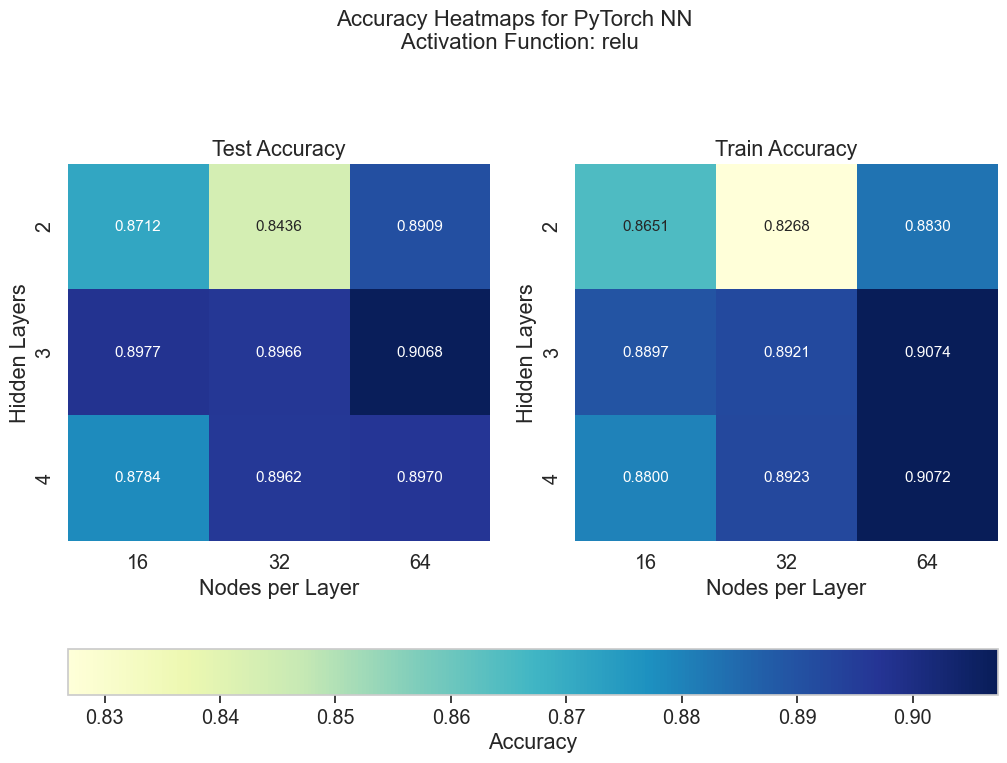

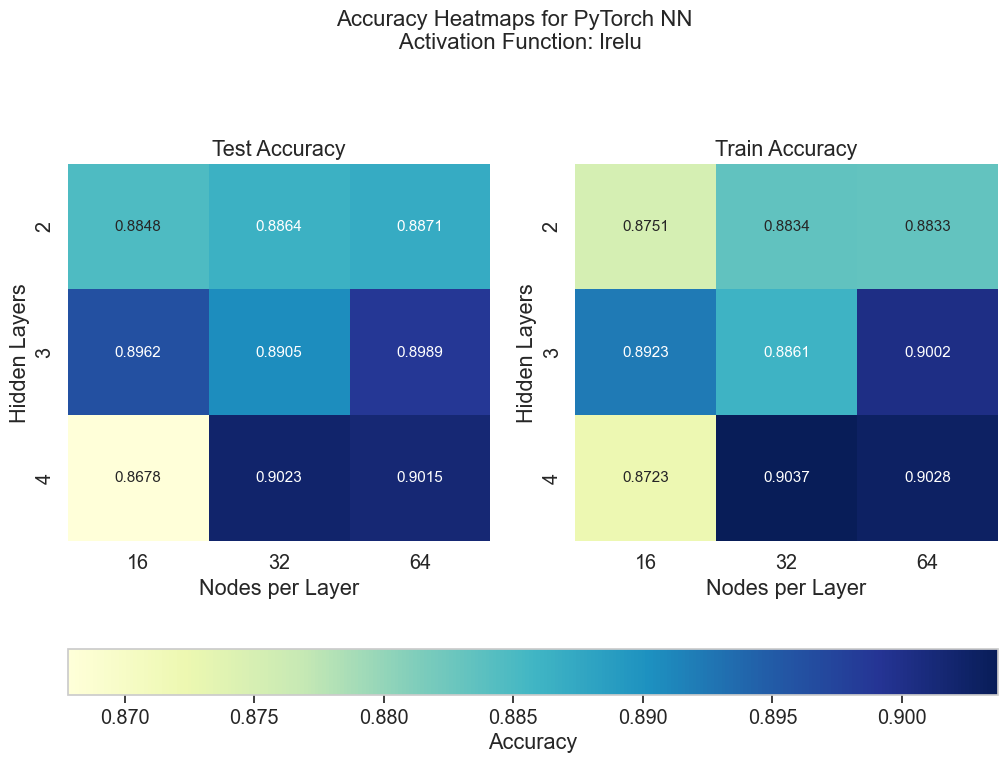

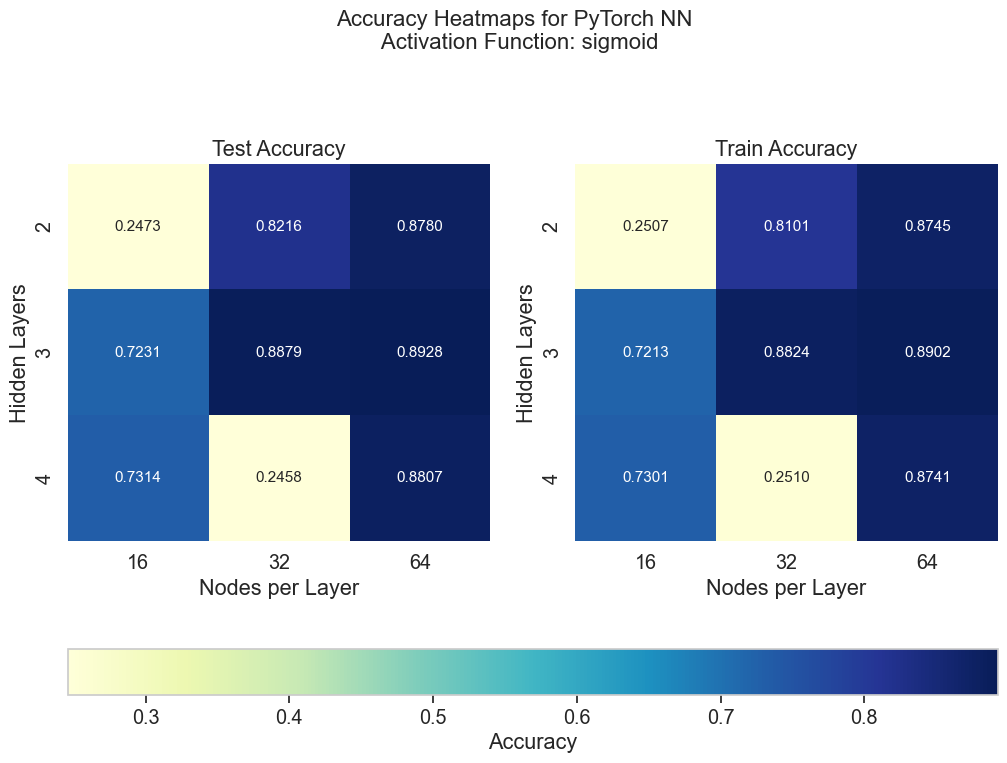

In [9]:
plt.rcParams.update({"font.size": 11})

for activation in activations:

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    fig.suptitle(f'Accuracy Heatmaps for PyTorch NN \n Activation Function: {activation}', y = 1.1, fontsize=16)

    pivot_table_test = results_torch_arch[results_torch_arch['Activation'] == activation].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_torch_arch[results_torch_arch['Activation'] == activation].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Nodes per Layer')
    ax[0].set_ylabel('Hidden Layers')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Nodes per Layer')
    ax[1].set_ylabel('Hidden Layers')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.2, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()


In [10]:
# Fidning the best architecture per activation function
best_torch_model_arch = results_torch_arch.loc[results_torch_arch.groupby('Activation')['Accuracy_test'].idxmax()]
best_torch_model_arch

,Activation,Hidden Layers,Nodes,Accuracy_train,Accuracy_test
16,lrelu,4,32,0.903693,0.902273
5,relu,3,64,0.907386,0.906818
23,sigmoid,3,64,0.890152,0.892803


### 2) Assessing the impact of learning rate and epoch size on accuracy

Here we inherit the best architectures found for each activation function, and explore how different learning rates and number of epochs affect the accuracy.

In [11]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
epoch_options = [10, 50, 100]
activations = ['relu', 'lrelu', 'sigmoid']

In [12]:
results = []

for activation in activations:
    for lr in learning_rates:
        for epochs in epoch_options:

            # Get the best architecture for the given activation function
            num_hidden_layers = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Hidden Layers'])
            num_of_nodes = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Nodes'])

            # Make a model for a given set of hyperparameters
            model = WeatherNN(input_dim=input_dim, hidden_dim=num_of_nodes, num_hidden_layers=num_hidden_layers, output_dim=num_classes, activation=activation)

            # Train the model
            training_model = model.train_model(train_loader, lr, epochs)

            # Evalute accuracy of model
            accuracy_train = model.evaluate(train_loader)
            accuracy_test  = model.evaluate(test_loader)

            print(f'Activation: {activation}, Learning rate: {lr}, Number of epochs: {epochs}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation,
                'Learning Rate': lr,
                'Epochs': epochs,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_86934/1883714739.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_hidden_layers = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Hidden Layers'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_86934/1883714739.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_of_nodes = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Nodes'])


Activation: relu, Learning rate: 0.0001, Number of epochs: 10, Test Accuracy: 0.8458
Activation: relu, Learning rate: 0.0001, Number of epochs: 50, Test Accuracy: 0.8879
Activation: relu, Learning rate: 0.0001, Number of epochs: 100, Test Accuracy: 0.8830
Activation: relu, Learning rate: 0.001, Number of epochs: 10, Test Accuracy: 0.8761
Activation: relu, Learning rate: 0.001, Number of epochs: 50, Test Accuracy: 0.9042
Activation: relu, Learning rate: 0.001, Number of epochs: 100, Test Accuracy: 0.9027
Activation: relu, Learning rate: 0.01, Number of epochs: 10, Test Accuracy: 0.8727
Activation: relu, Learning rate: 0.01, Number of epochs: 50, Test Accuracy: 0.8928
Activation: relu, Learning rate: 0.01, Number of epochs: 100, Test Accuracy: 0.9015
Activation: relu, Learning rate: 0.1, Number of epochs: 10, Test Accuracy: 0.2458
Activation: relu, Learning rate: 0.1, Number of epochs: 50, Test Accuracy: 0.2458
Activation: relu, Learning rate: 0.1, Number of epochs: 100, Test Accuracy: 0

In [13]:
results_torch_lrs = pd.DataFrame(results)

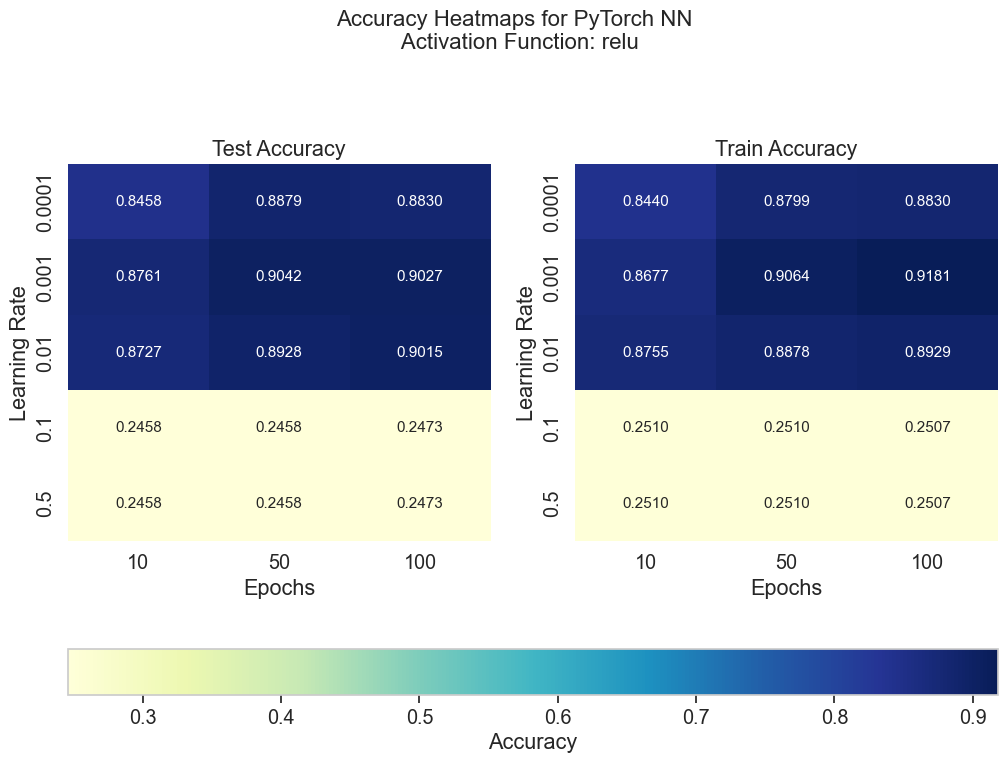

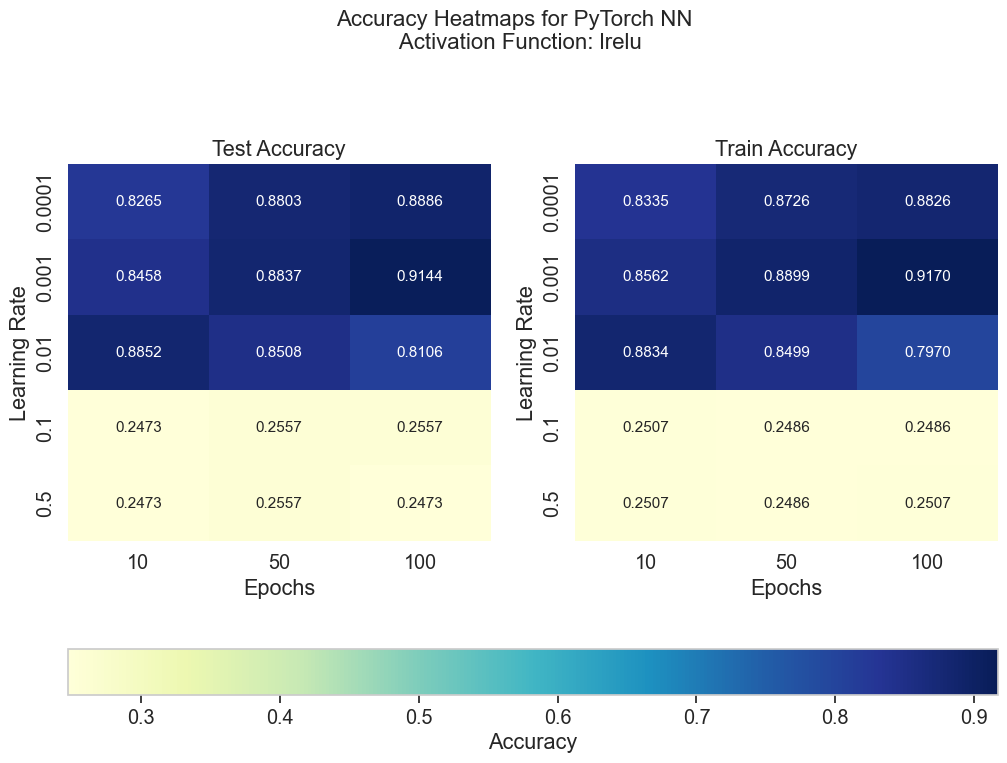

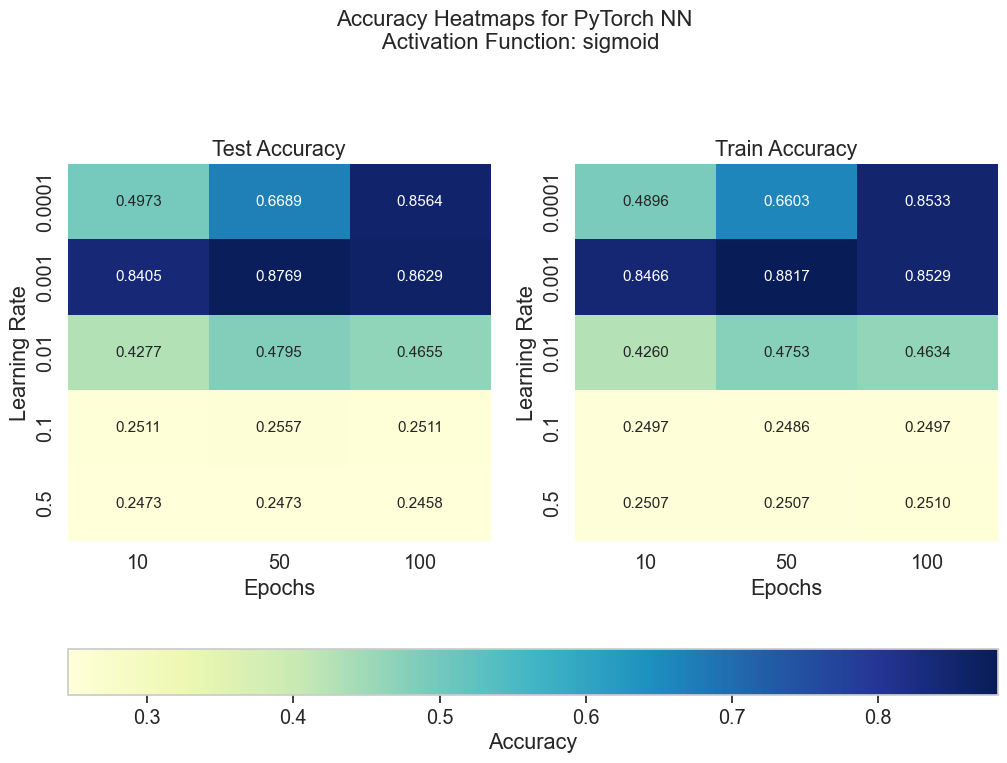

In [14]:
plt.rcParams.update({"font.size": 11})

for activation in activations:

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    fig.suptitle(f'Accuracy Heatmaps for PyTorch NN \n Activation Function: {activation}', y = 1.1, fontsize=16)

    pivot_table_test = results_torch_lrs[results_torch_lrs['Activation'] == activation].pivot_table(
        index="Learning Rate", columns="Epochs", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_torch_lrs[results_torch_lrs['Activation'] == activation].pivot_table(
        index="Learning Rate", columns="Epochs", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Learning Rate')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Learning Rate')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.2, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()

In [15]:
best_model_torch_lrs = results_torch_lrs.loc[results_torch_lrs.groupby('Activation')['Accuracy_test'].idxmax()]
best_model_torch_lrs

,Activation,Learning Rate,Epochs,Accuracy_train,Accuracy_test
20,lrelu,0.001,100,0.917045,0.914394
4,relu,0.001,50,0.906439,0.904167
34,sigmoid,0.001,50,0.881723,0.876894


### 3) Adding L1 and L2 regularization

Lastly, we train our PyTorch network with the best found acrhitecutre per activation and the best learning rate and epochs (for each activation respectively), but add regularization terms to penalize weights and help mitigate overfitting. We find this interesting to test as we know there are outliers in our dataset.



In [16]:
# Coming soon!

# Weather type classification using our own NN

We now repeat the same analysis done for our PyTorch network on our own FFNN code from Project 2.

In [17]:
# Read in the data
data = pd.read_csv(path)

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Create label encoders for each categorical column
encoders = {col: LabelEncoder() for col in cat_cols}

# Apply encoding
# String to numerical conversion
for col in cat_cols:
    data[col] = encoders[col].fit_transform(data[col]).astype(int)

X = data.drop('Weather Type', axis=1).values
y = data['Weather Type'].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

targets = np.zeros((len(y), 4))
for i, val in enumerate(y):
    targets[i, val] = 1
y = targets

# Spltit the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### 1) Exploring different network architectures for different activation functions

We start by training our network using different network constructions in terms of number of hidden layers and number of nodes per layer. This is done for three different activation functions, ReLU, LReLU and sigmoid.

In [18]:
learning_rate = 0.001
activations = [RELU, LRELU, sigmoid]
activation_names = ['relu', 'lrelu', 'sigmoid']

num_hidden_layers = [2, 3, 4]
num_of_nodes = [16, 32, 64]

epochs = 50
batch_size = 64

In [19]:
def evaluate_ffnn_classification(y_pred, y_true):
    pred_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)

    return np.mean(pred_class == true_class)

In [20]:
results = []

for activation, activation_name in zip(activations, activation_names):
    for hidden in num_hidden_layers:
        for nodes in num_of_nodes:

            # Make lists of activation functions and their derivatives
            # Output layer uses softmax activation
            activation_funcs = [activation] * hidden + [softmax]
            activation_ders  = [derivate(activation)] * hidden + [derivate(softmax)]
            
            # Make a model for a given set of hyperparameters
            model = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=[nodes] * hidden + [4],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=cross_entropy,
            cost_der=cross_entropy_der)

            # Train network with stochastic gradient descent and Adam optimizer
            model.train_SGD(X_train, y_train, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, optimizer='adam')

            # Make predictions
            y_pred_test = model._feed_forward(X_test)
            y_pred_train = model._feed_forward(X_train)

            # Compute accuracy
            accuracy_train = evaluate_ffnn_classification(y_pred_train, y_train)
            accuracy_test  = evaluate_ffnn_classification(y_pred_test, y_test)

            print(f'Activation: {activation_name}, Hidden Layers: {hidden}, Nodes: {nodes}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation_name,
                'Hidden Layers': hidden,
                'Nodes': nodes,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

Activation: relu, Hidden Layers: 2, Nodes: 16, Test Accuracy: 0.8098
Activation: relu, Hidden Layers: 2, Nodes: 32, Test Accuracy: 0.8250
Activation: relu, Hidden Layers: 2, Nodes: 64, Test Accuracy: 0.8231
Activation: relu, Hidden Layers: 3, Nodes: 16, Test Accuracy: 0.8432
Activation: relu, Hidden Layers: 3, Nodes: 32, Test Accuracy: 0.7955
Activation: relu, Hidden Layers: 3, Nodes: 64, Test Accuracy: 0.8155
Activation: relu, Hidden Layers: 4, Nodes: 16, Test Accuracy: 0.8114
Activation: relu, Hidden Layers: 4, Nodes: 32, Test Accuracy: 0.7830
Activation: relu, Hidden Layers: 4, Nodes: 64, Test Accuracy: 0.8178
Activation: lrelu, Hidden Layers: 2, Nodes: 16, Test Accuracy: 0.8095
Activation: lrelu, Hidden Layers: 2, Nodes: 32, Test Accuracy: 0.8242
Activation: lrelu, Hidden Layers: 2, Nodes: 64, Test Accuracy: 0.8220
Activation: lrelu, Hidden Layers: 3, Nodes: 16, Test Accuracy: 0.8428
Activation: lrelu, Hidden Layers: 3, Nodes: 32, Test Accuracy: 0.7955
Activation: lrelu, Hidden Lay

In [21]:
results_ffnn_arch = pd.DataFrame(results)

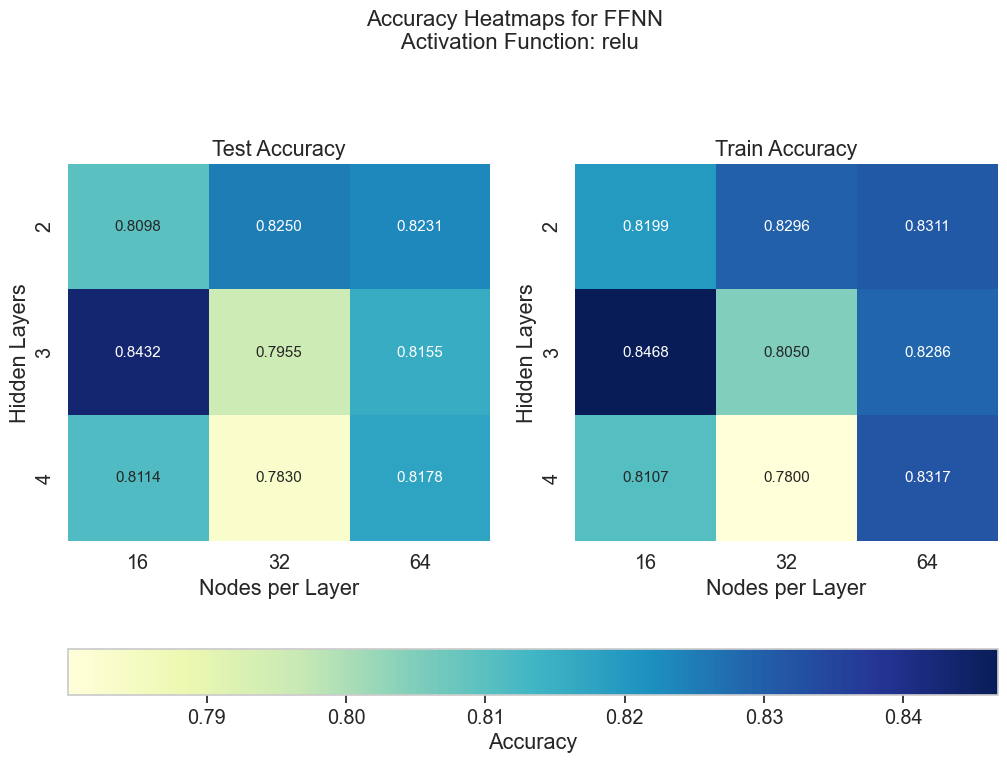

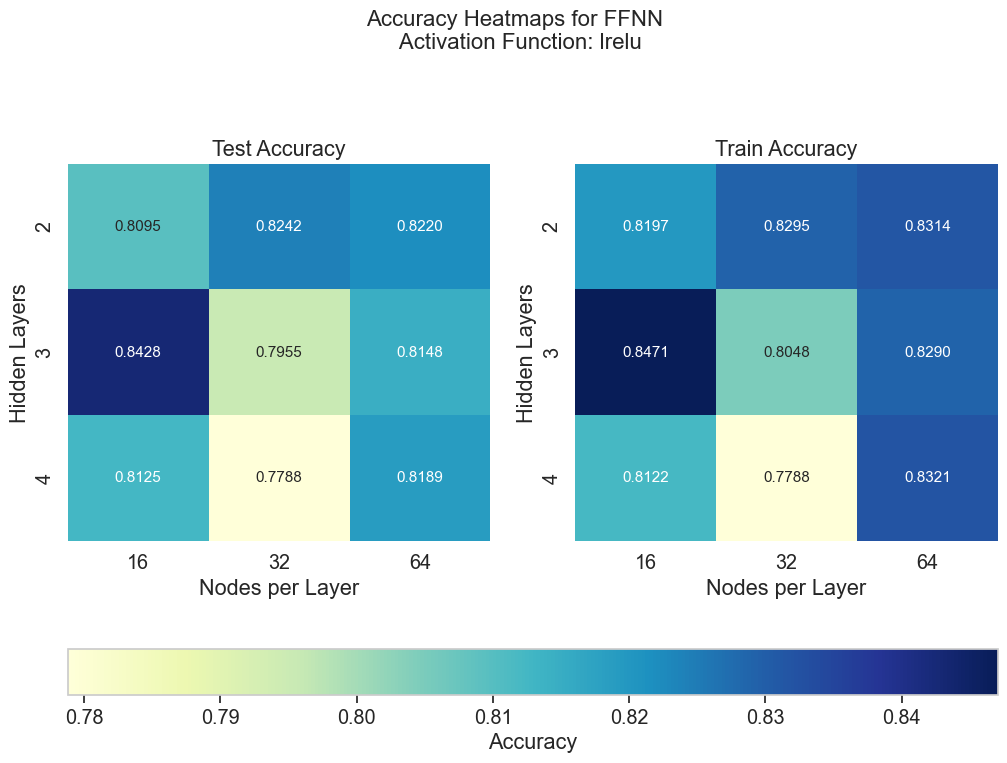

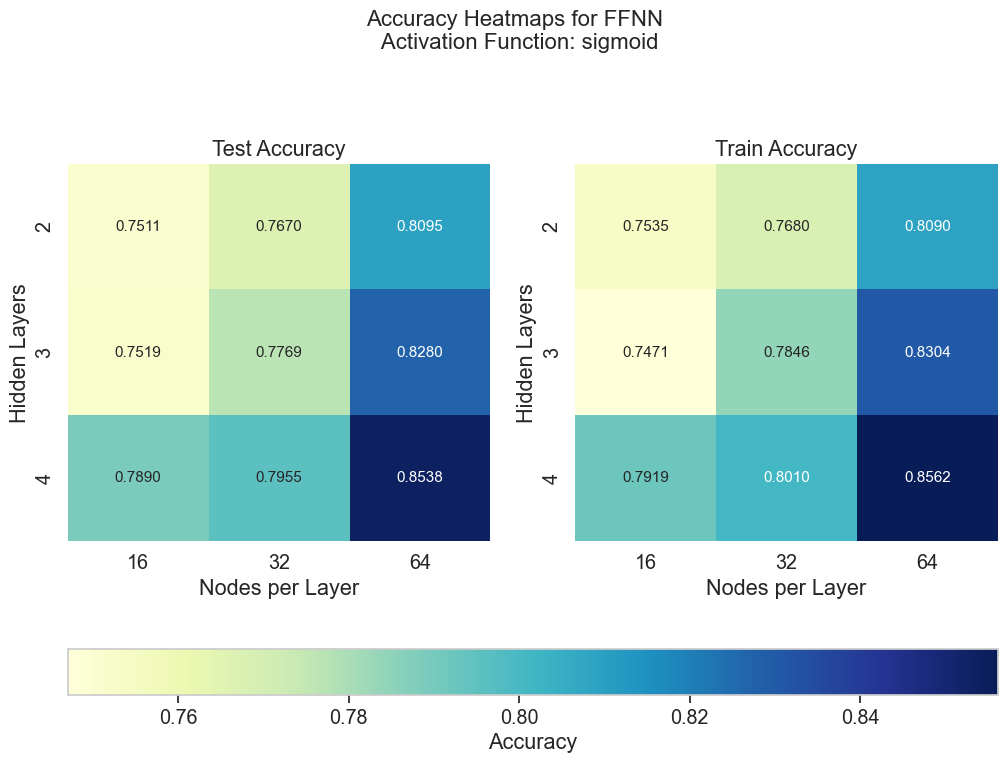

In [22]:
plt.rcParams.update({"font.size": 11})

for activation, activation_name in zip(activations, activation_names):

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    fig.suptitle(f'Accuracy Heatmaps for FFNN \n Activation Function: {activation_name}', y = 1.1, fontsize=16)
    pivot_table_test = results_ffnn_arch[results_ffnn_arch['Activation'] == activation_name].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_ffnn_arch[results_ffnn_arch['Activation'] == activation_name].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Nodes per Layer')
    ax[0].set_ylabel('Hidden Layers')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Nodes per Layer')
    ax[1].set_ylabel('Hidden Layers')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.2, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()